In [10]:
import glob
import re
import matplotlib.backends.backend_pdf

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab
import seaborn           as sns

from scipy       import stats
from prettytable import PrettyTable
from itertools   import product
from sklearn     import linear_model
from scipy.stats import rankdata
from scipy.stats import wilcoxon

sns.set()
plt.style.use('default')

print('Done')

Done


In [14]:
#Configurando as listas que serão percorridas nos plots

dss = [
    'airfoil', 
     #'concrete',
     #'energyCooling',
     #'energyHeating',
     #'towerData',
     #'wineRed',
     #'wineWhite',
     #'yacht'
]

_dss_labels = {
    'airfoil'       : 'Airfoil',
    'concrete'      : 'Concrete',
    'energyCooling' : 'Energy Cooling',
    'energyHeating' : 'Energy Heating',
    'towerData'     : 'Tower Data',
    'wineRed'       : 'Wine Red',
    'wineWhite'     : 'Wine White',
    'yacht'         : 'Yacth'
}
 
folds     = 1
reps      = 2

evol_path = './evolution_log/'
grid_path = './grid_log/'     

# Aqui vem os parâmetros fixados
default_params = {
    'popsize'  : 200,
    'gens'     : 500,
    'model'    : linear_model.LinearRegression(n_jobs=-1),
    'funs'     : {
        "id"      : lambda x: x,
        "sin"     : np.sin, 
        "cos"     : np.cos,        
        "tanh"    : np.tanh,
        "sqrt.abs": lambda x: np.sqrt(np.absolute(x)),
        "log"     : np.log, 
        "exp"     : np.exp,
    }
}
#Aqui devem ter todos os hp que estavam sendo variados no gridsearch
search_params = {
    'expolim'  : [(-3, 3), (-2, 2), (-1, 1), (0, 3), (0, 2), (0, 1)],
    'maxterms' : [5, 10, 15],
    'minterms' : [3, 4, 5] 
}

# Precisamos de apenas 2 eixos. A tupla abaixo indica como todos os search params
# devem ser combinados para resultar em apenas 2. Todos os search params
# devem estar em uma das duas listas
axis_params = (
    ['expolim'],
    ['maxterms', 'minterms']
)

axis_labels = (
    'Expolim',
    'min/max terms'
)

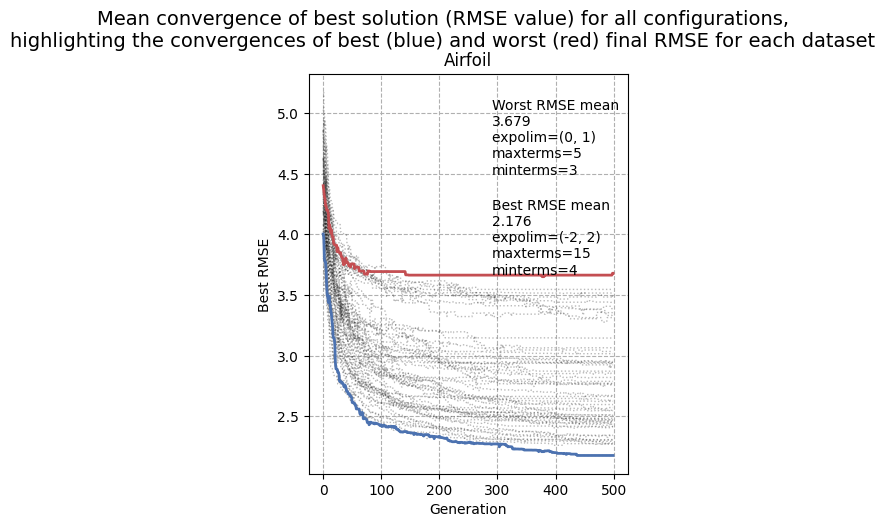

In [15]:
def _get_clean_conv(line):
    gens_without_nan  = []
    rmses_without_nan = []

    highest_nan = 0
    for xc, yc in zip(range(len(line)), line):
        if yc>1e+150:
            highest_nan = xc + 1
    
    return range(highest_nan, len(line)), line[highest_nan:]

def dict_string(d):
    #Converte um dicionário para uma string
    
    return '\n'.join([k+'='+str(v) for k, v in d.items()])

nrows, ncols = 1 + len(dss)//4, min(len(dss), 4)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 5.5*nrows))

axis_x = list(product(*[search_params[param] for param in axis_params[0]]))
axis_y = list(product(*[search_params[param] for param in axis_params[1]]))

for (ds, ax) in zip(dss, fig.axes):

    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
    
    # Convergência média ao longo dos folds-reps
    mean_conv  = np.zeros((
            len(hyperconfigs),
            default_params['gens']
    ))
    
    best_conv  = {'mean': None, 'std': None, 'hp': None}
    worst_conv = {'mean': None, 'std': None, 'hp': None}
    
    for idx, hp in enumerate(hyperconfigs):
        convs = []
        for f in range(folds):
            for r in range(reps):
                sufix = "-".join("=".join([k, str(v)]) for k, v in sorted(hp.items()))

                try:
                    resultsDF = pd.read_csv(f'{evol_path}{ds}-{f}-{r}-{sufix}.csv')

                    convs.append(resultsDF['bestfit'])
                except:
                    print(f'execução com fold {f} e rep {r} não existe')
                    
        mean_conv[idx, :] = np.mean(convs, axis=0)
                
    for line in mean_conv:
        gens_without_nan, rmses_without_nan = _get_clean_conv(line)
        ax.plot(gens_without_nan, rmses_without_nan, 'k', alpha=0.3, linestyle='dotted', linewidth=1)

    best_idx = np.argmin(mean_conv[:, -1])
    gens_without_nan, rmses_without_nan = _get_clean_conv(mean_conv[best_idx, :])
    ax.plot(gens_without_nan, rmses_without_nan,  c='b', linestyle='solid', linewidth=2)
    
    worst_idx = np.argmax(mean_conv[:, -1])
    gens_without_nan, rmses_without_nan = _get_clean_conv(mean_conv[worst_idx, :])
    ax.plot(gens_without_nan, rmses_without_nan, c='r', linestyle='solid', linewidth=2)
    
    ax.set_title(_dss_labels[ds])
    
    ax.annotate( #média do melhor RMSE na última geração
        f'Best RMSE mean\n{round(mean_conv[best_idx, -1], 3)}\n{dict_string(hyperconfigs[best_idx])}',
        xy=(0.575, 0.5), xycoords='axes fraction'
    )
    
    if mean_conv[worst_idx, -1] < 1e+150:
        ax.annotate( #média do pior RMSE na última geração
            f'Worst RMSE mean\n{round(mean_conv[worst_idx, -1], 3)}\n{dict_string(hyperconfigs[worst_idx])}',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    else:
        ax.annotate( #média do pior RMSE na última geração
            f'Worst RMSE mean\nDid not converge',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    
    ax.set_ylabel('Best RMSE')
    ax.set_xlabel('Generation')
    
    ax.grid(True, linestyle='--')
    
fig.suptitle(
    f'Mean convergence of best solution (RMSE value) for all configurations,\n\
highlighting the convergences of best (blue) and worst (red) final RMSE for each dataset',
            verticalalignment='top', fontsize = 14)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

fig.savefig(f'convergence-allconf.pdf', bbox_inches='tight')

In [16]:
#Definindo funções auxiliares para pegar os dados

def get_final_rmse_raw(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas não calcula a média antes de retornar
    final_rmses = []
    
    for f in range(folds):
        for r in range(reps):
            
            resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
            
            for k, v in params.items():
                #Encontrando a métrica, percorrendo cada item do dicionário params
                resultsDF = resultsDF[resultsDF[k].astype(str)==str(v)]

            #Primeiro passo criando uma matriz com cada convergencia
            final_rmses.append(resultsDF[metric].tolist()[0])
    
            if np.isnan(resultsDF[metric].tolist()[0]):
                print('NaN na configuração', ds, f, r, params)

    return final_rmses

def get_final_rmse_median(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas só pega o RMSE final, aqui eu busco 
    #nos arquivos do grid_log, que tem todas as métricas (rmse, mae, nmse)
    #e a expressão de melhor fit
    
    #Exemplo de uso: get_final_rmse_mean({'expolim':1, 'max_terms':4}, 'airfoil')
    
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    
    m = np.median([f for f in final_rmses if not np.isnan(f)], axis=0)
    
    return m


/home/galdeia/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


[['\\textbf{3.03*}', '\\textbf{2.69*}', '\\textbf{2.63*}'], ['\\textbf{3.02*}', '\\textbf{2.62*}', '\\textbf{2.67*}'], ['\\textbf{3.27*}', '\\textbf{2.71*}', '\\textbf{\\underline{2.57}}'], ['\\textbf{3.63*}', '\\textbf{3.09*}', '\\textbf{2.83*}'], ['\\textbf{3.61*}', '\\textbf{3.0*}', '\\textbf{2.9*}'], ['\\textbf{3.9*}', '\\textbf{3.36*}', '\\textbf{2.91*}']]


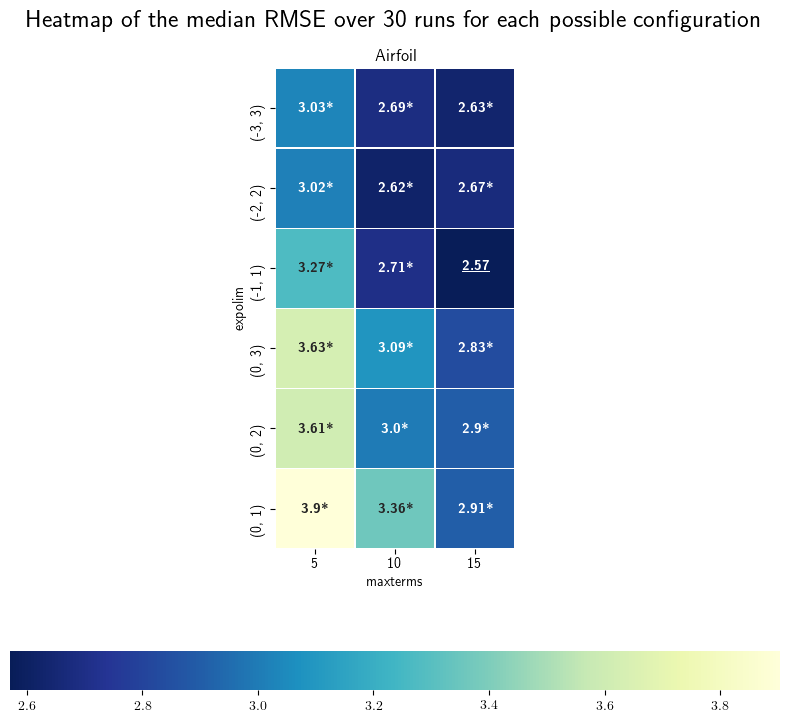

In [17]:
#Caso sejam variados apenas 2 parâmetros, podemos plotar um heatmap

def check_pv(arg):
    x, y = arg
    if np.isnan(x) or np.isnan(y):
        return False
    return True


plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(8, 8))
    
title = f'Heatmap of the median RMSE over 30 runs for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
            

grid   = []
best        = {'expolim': search_params['expolim'][0], 'maxterms':search_params['maxterms'][0]}
best_median = get_final_rmse_median(best, ds)

#Criando todas as combinações dos hiper-parâmetros
keys, values = zip(*search_params.items())
hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]

for hp1 in search_params['expolim']:

    line = []

    for hp2 in search_params['maxterms']:

        final_rmse_median = get_final_rmse_median({'expolim':hp1, 'maxterms':hp2}, ds)
        line.append(final_rmse_median)

        if final_rmse_median < best_median:
            best_median = final_rmse_median
            best = {'expolim':hp1, 'maxterms':hp2}

    grid.append(line)


best_raw = get_final_rmse_raw(best, ds)

# Criando os labels
labels = []
for i, hp1 in enumerate(search_params['expolim']):     
    line = []
    for j, hp2 in enumerate(search_params['maxterms']):

        if hp1 == best['expolim'] and hp2 ==best['maxterms']:
            line.append(r'\textbf{\underline{' + str(round(grid[i][j], 2)) + '}}')
        else:
            hp_raw = get_final_rmse_raw({'expolim':hp1, 'maxterms':hp2}, ds)

            hp_raw_filtered, best_raw_filtered = zip(* filter(check_pv, zip(hp_raw, best_raw)) )

            w, p = wilcoxon(hp_raw_filtered, best_raw_filtered)

            if p>0.05:
                line.append(r'\textbf{' + str(round(grid[i][j], 2)) +'*}')
            else:
                line.append(r'' + str(round(grid[i][j], 2)) + '')
    labels.append(line)

print(labels)
# Mais escuro -> menor RMSE, melhor é o resultado; mais claro -> pior
sns.heatmap(data=np.array(grid), ax=ax, annot=np.array(labels), linewidths=.5, #center=0.0,
             #cmap=sns.light_palette('black', reverse=True),
             cmap="YlGnBu_r",
             square=True,
             cbar_kws={"orientation": "horizontal"}, fmt='', #fmt='.3g', #vmin=-1.0,
             xticklabels=search_params['maxterms'], yticklabels=search_params['expolim'],
           )

ax.set_title(_dss_labels[ds])
ax.set_ylabel('expolim')
ax.set_xlabel('maxterms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'heatmap-medianRMSE.pdf', bbox_inches='tight')